# Vizualisation of failure cases

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import os
import rasterio
from rasterio.windows import Window
import numpy as np

proj_dir = os.path.dirname(os.getcwd())
exp_dir = os.path.join(proj_dir, 'output')

In [ ]:
set = 'mylabels_test'
input_dir = os.path.join(os.path.dirname(os.path.dirname(proj_dir)), 'Data', 'SwissImage')

In [3]:
alpha = 1.0
alpha_prev = 0.5

red = np.array([234, 32, 39, 255 * alpha]) / 255
yellow = np.array([255, 195, 18, 255 * alpha]) / 255
gray = np.array([100, 100, 100, 255 * alpha]) / 255
pink = np.array([253, 167, 223, 255 * alpha]) / 255
orange = np.array([238, 90, 36, 255 * alpha]) / 255
white = np.array([255, 255, 255, 255 * alpha]) / 255
black = np.array([0, 0, 0, 255 * alpha]) / 255

colormap_pred = np.zeros((256, 4))
colormap_pred[1] = yellow
colormap_pred[-1] = gray

fig_scale = 5

In [4]:
def hide_axis(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_color((0.0,)*4)
    ax.spines['top'].set_color((0.0,)*4) 
    ax.spines['right'].set_color((0.0,)*4)
    ax.spines['left'].set_color((0.0,)*4)

In [5]:
def plot_results(exp_name_list,
                 exp_short_name_list,
                 epoch_list,
                 tk,               
                 year,
                 n_previous=None,
                 n_next=None,
                 x_start=0,
                 y_start=0,
                 patch_size=250,
                 year_list=None):
    dir_list = [os.path.join(exp_dir, exp_name, 'inference', 'epoch_{}'.format(epoch), set) for exp_name, epoch in zip(exp_name_list, epoch_list)]
    
    for i in range(len(exp_name_list)):
        
        if isinstance(year, list):    
            pred_im_list = []
            year_list = year
            
            for y in year_list:
                if y is None:
                    pred_im_list.append(None)
                else:
                    im_next_fn = os.path.join(dir_list[i], 'predictions_{}_{}.tif'.format(y, tk))
                    if os.path.isfile(im_next_fn):
                        with rasterio.open(im_next_fn, 'r') as f_next:
                            im = f_next.read(1, window=Window(x_start, y_start, patch_size, patch_size))
                            pred_im_list.append(im)
            
            pred_im_list = [v if v is not None else np.empty_like(im) for v in pred_im_list]                
                    
        else:
            # read prediction
            im_fn = os.path.join(dir_list[i], 'predictions_{}_{}.tif'.format(year, tk))
            with rasterio.open(im_fn, 'r') as f:
                im = f.read(1, window=Window(x_start, y_start, patch_size, patch_size))
            pred_im_list = [im]
            year_list = [year]
            # look for next prediction(s)
            count = 0
            year_next = year + 1
            while count < n_next and year_next <= 2020:
                im_next_fn = os.path.join(dir_list[i], 'predictions_{}_{}.tif'.format(year_next, tk))
                if os.path.isfile(im_next_fn):
                    with rasterio.open(im_next_fn, 'r') as f_next:
                        pred_im_list.append(f_next.read(1, window=Window(x_start, y_start, patch_size, patch_size)))
                        year_list.append(year_next) 
                    count += 1
                year_next += 1
        
            # look for previous prediction(s)
            count = 0
            year_previous = year - 1
            while count < n_previous and year_previous >= 1946:
                im_previous_fn = os.path.join(dir_list[i], 'predictions_{}_{}.tif'.format(year_previous, tk))
                if os.path.isfile(im_previous_fn):
                    with rasterio.open(im_previous_fn, 'r') as f_previous:
                        pred_im_list = [f_previous.read(1, window=Window(x_start, y_start, patch_size, patch_size))] + pred_im_list
                        year_list = [year_previous] + year_list
                        count += 1
                year_previous -= 1
                
        
        if i == 0:
            # read input images
            input_im_list = []
            for y in year_list:
                if y is None:
                    input_im_list.append(None)
                else:
                    input_fn = os.path.join(input_dir, str(y), '100cm', 'DOP100_LV95_{}_{}.tif'.format(tk, y))
                    with rasterio.open(input_fn, 'r') as f_input:
                        input_im_list.append(np.moveaxis(f_input.read(window=Window(x_start, y_start, patch_size, patch_size)),
                                                         (0, 1, 2), 
                                                         (2, 0, 1)))
            nrows = 1 + len(exp_name_list)
            n_years = len(year_list)
            width_ratios = [0.1 if y is None else 1 for y in year_list]
            fig, ax = plt.subplots(nrows=nrows, 
                                   ncols=n_years, 
                                   figsize=(fig_scale*np.sum(np.array(width_ratios)), fig_scale*nrows),
                                   gridspec_kw={'width_ratios': width_ratios})
            ax[i, 0].set_ylabel('aerial image', rotation=90, size=42)
            current_col = 0
            for j, (input_im, pred_im, y) in enumerate(zip(input_im_list, pred_im_list, year_list)):
                hide_axis(ax[i, current_col])
                if j == len(year_list) - 1:
                    scalebar = ScaleBar(1.0,
                                        length_fraction=0.5,
                                        font_properties={"size": 36})
                    ax[i, current_col].add_artist(scalebar)
                if y is None:
                    if year_list[j-1] is not None:
                        ax[i, current_col].text(0.5, 0.5, '...', 
                                                fontsize=42, 
                                                ha='center')
                        current_col += 1
                else:
                    cmap='gray' if input_im.shape[-1] == 1 else None
                    ax[i, current_col].imshow(input_im, cmap=cmap)
                    ax[i, current_col].set_title(str(y), size=42)
                    current_col += 1
                            
        # plot predictions
        ax[i+1, 0].set_ylabel('prediction\n{}'.format(exp_short_name_list[i]), rotation=90, size=42)
        current_col = len(year_list) - 1
        j = len(year_list) - 1
        for (input_im, pred_im, y) in zip(reversed(input_im_list), reversed(pred_im_list), reversed(year_list)):
            hide_axis(ax[i+1, current_col])
            if y is None:
                if year_list[j-1] is not None:
                    ax[i+1, current_col].text(0.5, 0.5, '...', 
                                              fontsize=42, 
                                              ha='center')
                    current_col -= 1
            else:
                cmap='gray' if input_im.shape[-1] == 1 else None
                ax[i+1, current_col].imshow(input_im, cmap=cmap)
                ax[i+1, current_col].imshow(colormap_pred[pred_im])
                current_col -= 1
            j -= 1


## Rare pattern

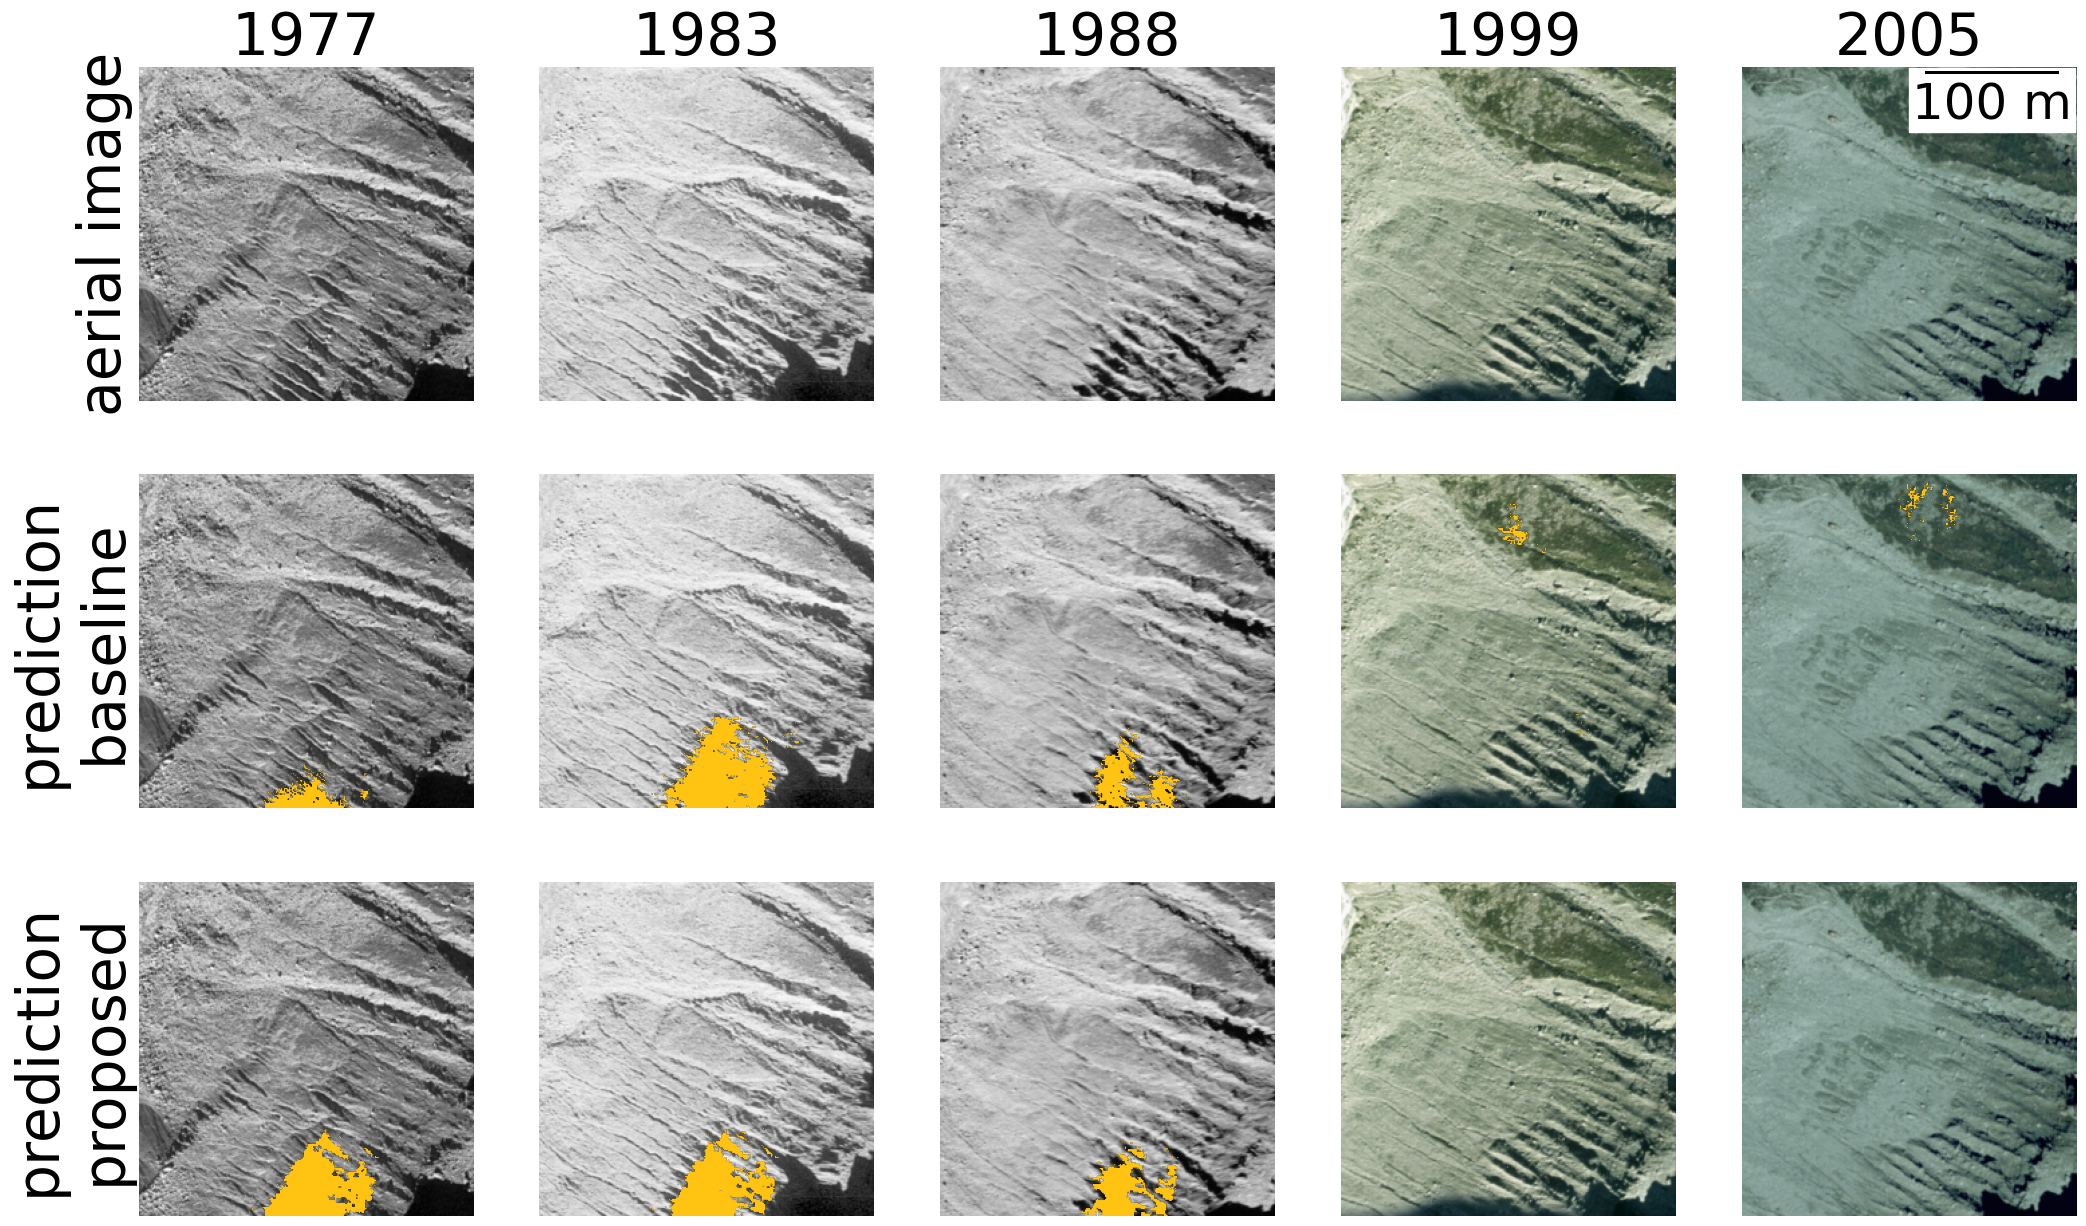

In [6]:
unet_exp_name = 'Unet_SI2020_100cm_grayaugment_rs4'
irreggru_exp_name = 'NIrregGRU7df_bwrd_freeze0_lrfe1em06_lrtemp0_0001_tlossCE_asymgraddot_ltemp1_0_1_0_rs1'
exp_name_list = [unet_exp_name, irreggru_exp_name]
exp_short_name_list = ['baseline','proposed']
epoch_list = [19, 39]

tk = '2615_1104'
year = 1988
n_previous = 2
n_next = 2

x_start = 350
y_start = 650
patch_size = 250

plot_results(exp_name_list,
             exp_short_name_list,
             epoch_list=epoch_list,
             tk=tk,               
             year=year,               
             n_previous=n_previous,               
             n_next=n_next,               
             x_start=x_start,               
             y_start=y_start,
             patch_size=patch_size)

## Shrub forest

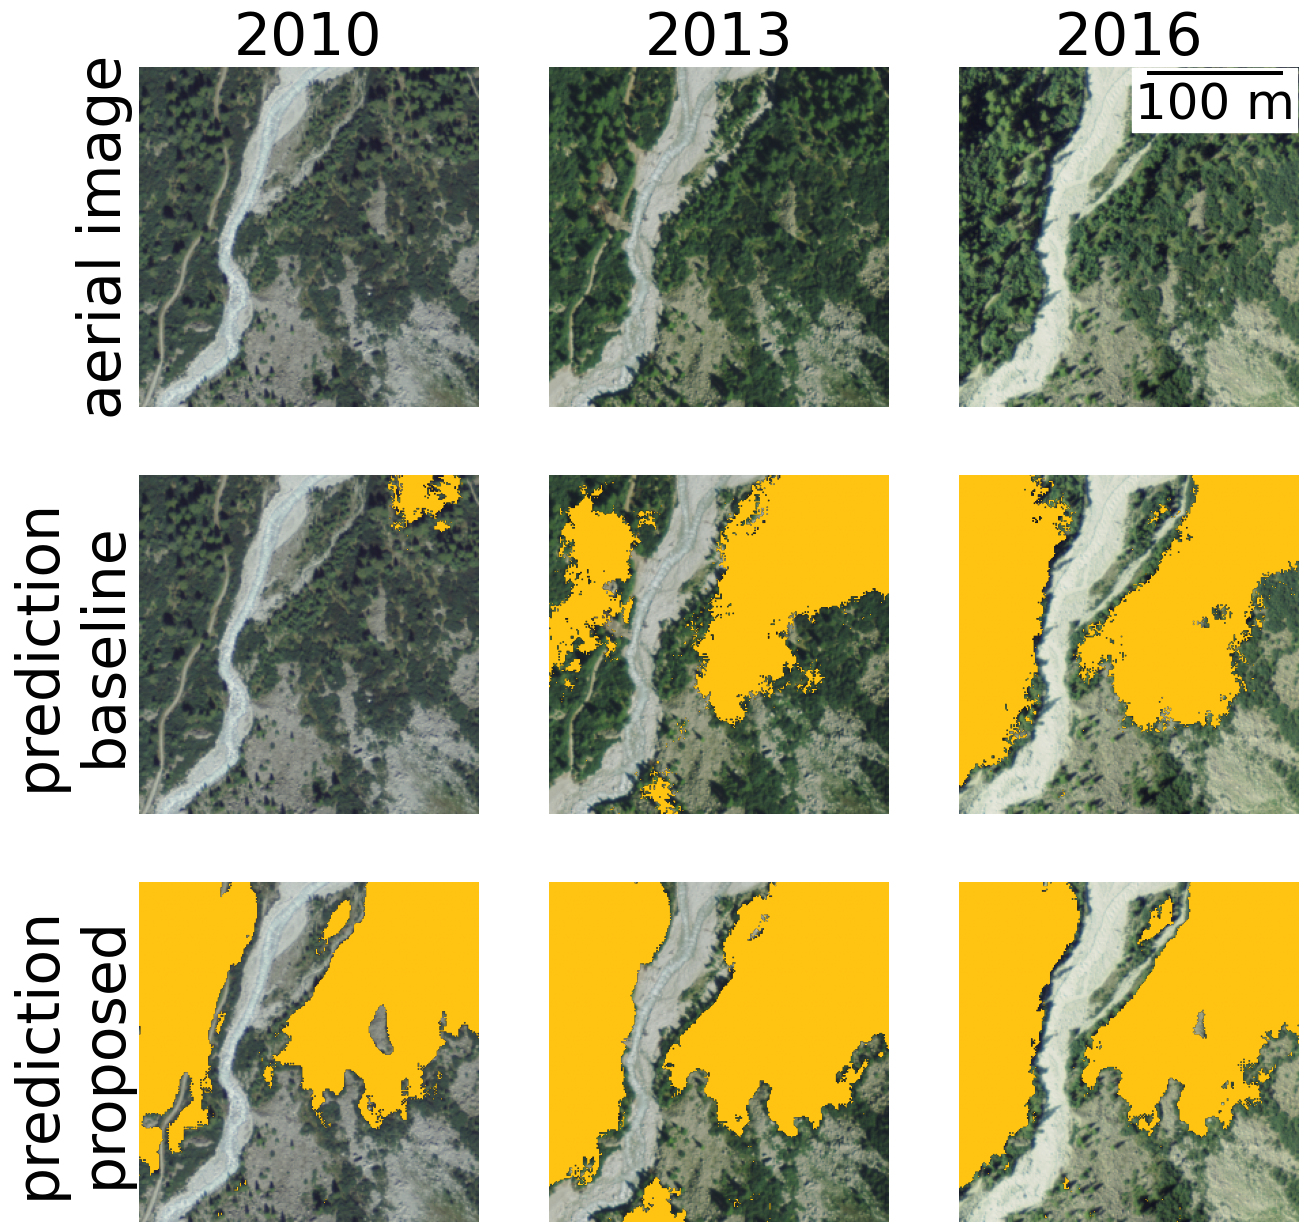

In [7]:
tk = '2615_1104'
year = [2010, 2013, 2016]
x_start = 350
y_start = 64
patch_size = 250

plot_results(exp_name_list,
             exp_short_name_list,
             epoch_list=epoch_list,
             tk=tk,               
             year=year,               
             x_start=x_start,               
             y_start=y_start,
             patch_size=patch_size)